This example notebook runs OCR with Tesseract and aligns OCR and SGT words.

*Make sure you have:*
1. Run `example_split_tex.ipynb`
2. Compiled the TeX to a PDF

In [123]:
tmp_dir = '/Users/jnaiman/Downloads/tmp/tiff_files/' # where to save tiff files temporarily

In [201]:
lib_dir = '../'
from sys import path
path.append(lib_dir)

from PIL import Image
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pytesseract
from lxml import etree

# debug
from importlib import reload
import utils
reload(utils)

from utils import error_and_quit, parse_page, count_pdf_pages, \
  find_positions, get_hyp_top_bottom, get_ocr_words, \
  plot_ocr_words

from image_utils import save_pages

error_out = True
ignore_quit = False

# for plotting, assuming 11pt fontsize
#1em = 12pt = 16px = 100%
fsize = 11 # pt
fpix = round(fsize*12/16.)

configOCR="--oem 1 --psm 3"
#lang='eng+equ'
lang='eng+ell+equ+lat'
fac_dpi = 4

Parse .aux file for locations of tikzmarks:

In [125]:
aux_file = './example_tex/mnras_template_clean_marked.aux'
pdf_file = './example_tex/mnras_template_clean_marked.pdf'
tex_file = './example_tex/mnras_template_clean_marked.tex'

# load aux file
with open(aux_file,'r') as f:
    aux = f.readlines()

In [126]:
# ---- parse aux file to get tikzmarks ----
# main body words
xs_main, ys_main, xe_main, ye_main, \
   pStart_main, pEnd_main, tStart_main, tEnd_main, \
   mStart_main, mEnd_main, error = find_positions(aux, 
                                                  marker='mainBody',
                                                  error_out=error_out)
if error: 
    error_and_quit('issue with main words',ignore_quit=ignore_quit)
    
# main body inline math
xs_mmath, ys_mmath, xe_mmath, ye_mmath, \
   pStart_mmath, pEnd_mmath, tStart_mmath, tEnd_mmath, \
   mStart_mmath, mEnd_mmath, error = find_positions(aux, 
                                                    marker='mainInline',
                                                    error_out=error_out)
if error: 
    error_and_quit('issue with main math',ignore_quit=ignore_quit)  

Pick a page to visualize:

In [127]:
count_pdf_pages(pdf_file) # how many pages?

8

In [128]:
ipage = 2

Save this as a TIFF file for OCR'ing:

In [129]:
page_errors = save_pages(tex_file, 
           [ipage],tmp_dir,check_exist=False, 
          save_fmt = 'tiff', 
          beginner='mnras_test_', return_error=True)

In [130]:
page_errors

[False]

## SGT words

Let's get where the SGT words are on this page:

In [131]:
img_file = tmp_dir + 'mnras_test_' + tex_file.split('.tex')[0].split('/')[-1] + '_p' + str(ipage) + '.tiff'
img_file

'/Users/jnaiman/Downloads/tmp/tiff_files/mnras_test_mnras_template_clean_marked_p2.tiff'

In [132]:
img = np.array(Image.open(img_file).convert('RGB'))
img_size = img.shape[:2]

In [133]:
img_size

(3129, 2381)

In [189]:
pdf_mark_order_full = []
word_pdf_full = [] 
hyp_full = []
hyp_order_full = []


# -------- words ---------
word_pdf, pdf_mark_order, \
   hyp, order_hyp = parse_page(tex_file, img_size, ipage, 
               xs_main,ys_main,xe_main,ye_main,
               mStart_main,mEnd_main,pStart_main, pEnd_main,
              mtype='mainBody', order_tag = 'word')

word_pdf_full.extend(word_pdf)
pdf_mark_order_full.extend(pdf_mark_order)
hyp_full.extend(hyp)
hyp_order_full.extend(order_hyp)


# ---------- math inline ----------------
word_pdf, pdf_mark_order, \
   hyp, order_hyp = parse_page(tex_file, img_size, ipage, 
               xs_mmath, ys_mmath, xe_mmath, ye_mmath,
               mStart_mmath, mEnd_mmath, 
               pStart_mmath, pEnd_mmath,
              mtype='mainInline', order_tag = 'inline')

word_pdf_full.extend(word_pdf)
pdf_mark_order_full.extend(pdf_mark_order)
hyp_full.extend(hyp)
hyp_order_full.extend(order_hyp)

# ----------- all hyphenated -------------------
# get hyphenated tops and bottoms from prior/subsequent line's info
hyp_not_tracked = []
for hyp_f, hyp_o in zip(hyp_full, hyp_order_full):
    hyp_tops, hyp_bottoms = get_hyp_top_bottom([hyp_f], word_pdf_full, [hyp_o], 
                                               pdf_mark_order_full, 
                                               verbose=False)
    if len(hyp_tops) > 0 and len(hyp_bottoms)>0:
        word_pdf_full.extend(hyp_tops)
        pdf_mark_order_full.append((hyp_o[0]+'-top',hyp_o[1]))
        word_pdf_full.extend(hyp_bottoms)
        pdf_mark_order_full.append((hyp_o[0]+'-bottom',hyp_o[1]+0.5)) # add 0.5 for sorting later
    else:
        hyp_not_tracked.append((hyp_f, hyp_o))

In [190]:
imgsgt = img.copy()

lthick = 2

# also, from full list
for (xmin,ymin,xmax,ymax,w,r),t in zip(word_pdf_full,pdf_mark_order_full):
    if t[0] == 'word':
        cv.rectangle(imgsgt, (xmin,ymin-fpix*fac_dpi),(xmax,ymax), (255,125,0), lthick)
    elif t[0] == 'inline':
        cv.rectangle(imgsgt, (xmin,ymin-fpix*fac_dpi),(xmax,ymax), (0,255,0), lthick)
    elif t[0] == 'cite':
        cv.rectangle(imgsgt, (xmin,ymin-fpix*fac_dpi),(xmax,ymax), (0,255,255), lthick)
    elif 'hyp-' in t[0]: # hyphentated
        if 'cite' in t[0]:
            cv.rectangle(imgsgt, (xmin,ymin-fpix*fac_dpi),(xmax,ymax), (0,125,125), lthick)
        elif 'inline' in t[0]:
            cv.rectangle(imgsgt, (xmin,ymin-fpix*fac_dpi),(xmax,ymax), (0,125,0), lthick)
        else:
            cv.rectangle(imgsgt, (xmin,ymin-fpix*fac_dpi),(xmax,ymax), (125,125,0), lthick)

## OCR words

Now let's OCR the tiff page to get the OCR words:

In [195]:
hocr = pytesseract.image_to_pdf_or_hocr(img.copy(),  
                                        config=configOCR, 
                                        extension='hocr', 
                                       lang=lang)
hocrOSD = pytesseract.image_to_osd(img.copy(), 
                                   config="--psm 0", 
                                   lang=lang, 
                                   output_type=pytesseract.Output.DICT)

In [196]:
# debug
from importlib import reload
import utils
reload(utils)

from utils import get_ocr_words

In [198]:
# translate to text to find namespace for xpath
htmlText = None
try:
    htmlText = hocr.decode('utf-8')
except:
    print('NOPE -- cant decode hocr as utf-8, page=',ipage )

    # grab namespace
nameSpace = ''
if htmlText is not None:
    for l in htmlText.split('\n'):
        if 'xmlns' in l:
            nameSpace = l.split('xmlns="')[1].split('"')[0]
            break
    tree = etree.fromstring(hocr)
    ns = {'tei': nameSpace}

In [199]:
words_ocr = get_ocr_words(tree, ns)

In [213]:
imgOCR = img.copy()
imgOCR[:,:,:] = 255 # set all to white

# draw words
words_plot = []
for (x,y,w,h,r,c,f,l,li),pw in words_ocr:
    xmin = round(x); xmax=round((x+w))
    ymin = round(y); ymax = round((y+h))
    cv.rectangle(imgOCR, (xmin,ymin), (xmax,ymax), (125,0,200), lthick)
    words_plot.append( ((x,y,w,h,r,c,f,l),pw) )
    
imgOCR = plot_ocr_words(imgOCR,words_plot,font_size=30)

## Plot all words

Put it all together and plot

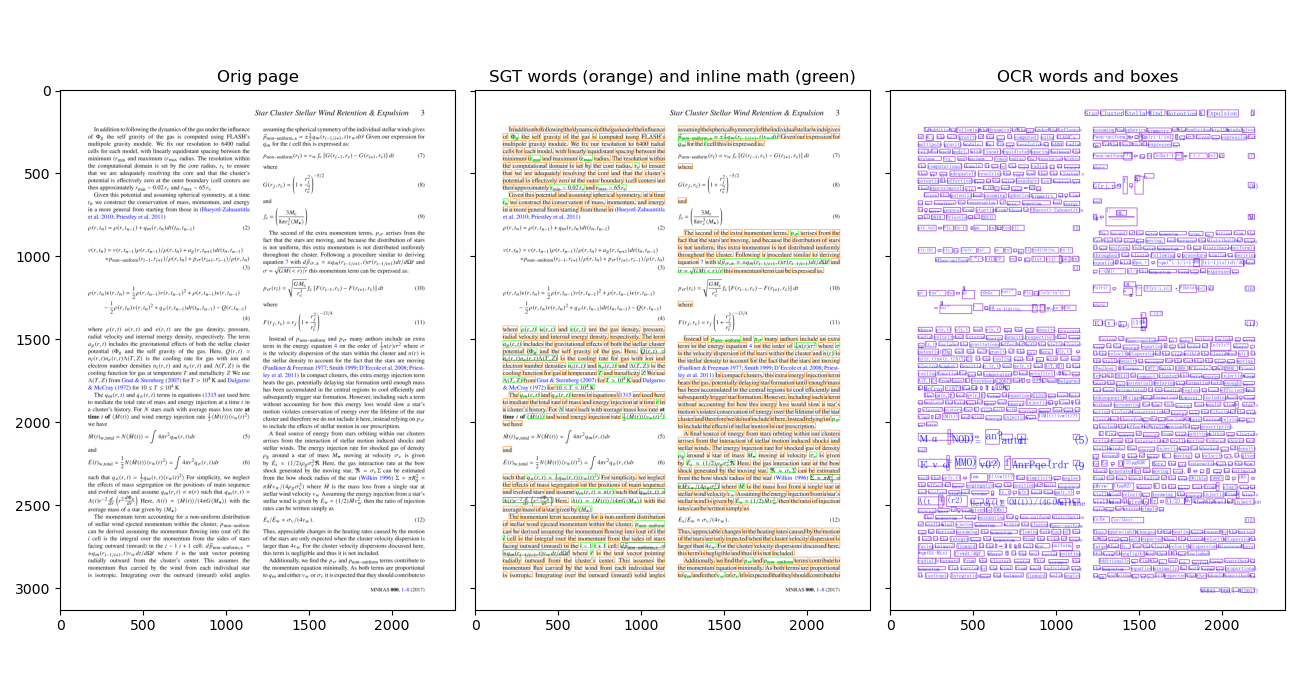

In [214]:
%matplotlib widget

plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(13,7),sharex=True,sharey=True)

ax[0].imshow(img)
ax[0].set_title("Orig page")

ax[1].imshow(imgsgt)
ax[1].set_title('SGT words (orange) and inline math (green)')

ax[2].imshow(imgOCR)
ax[2].set_title('OCR words and boxes')

fig.tight_layout()

plt.show()

## Align SGT and OCR words

Finally, let's run the alignment routine to match up OCR and SGT words for this page:

In [228]:
alignment = align_sgt_ocr(words_ocr, word_pdf_full, pdf_mark_order_full)

Output is each SGT word, in terms of its tikzmark number and its aligned OCR words.

In [231]:
alignment[1473]

{'PDF word': {'word': 'In',
  'raw': 'In',
  'xmin': 204,
  'ymin': 240,
  'xmax': 234,
  'ymax': 248,
  'hyphenated': False,
  'assumed fontsize transformations': {'fontsize': 11, 'fpix': 8},
  'word type': 'word'},
 'OCR words': {'In': {'xmin': 205,
   'ymin': 224,
   'xmax': 233,
   'ymax': 248,
   'rotation': 0.0,
   'confidence': 96,
   'font size': 33.0,
   'languages': ['eng'],
   'baseline0': 0.0,
   'baseline1': -8.0,
   'descenders': 8.0,
   'ascenders': 8.0,
   'lineID': 'line_1_1'}}}

Find all inline math:

In [234]:
for k,v in alignment.items():
    if 'PDF word' in v:
        if v['PDF word']['word type'] == 'inline':
            print(k,v)
            print('')

1487 {'PDF word': {'word': '$\\Phi_g$', 'raw': '$\\Phi_g$', 'xmin': 216, 'ymin': 284, 'xmax': 263, 'ymax': 292, 'hyphenated': False, 'assumed fontsize transformations': {'fontsize': 11, 'fpix': 8}, 'word type': 'inline'}, 'OCR words': {'@,g': {'xmin': 217, 'ymin': 268, 'xmax': 260, 'ymax': 303, 'rotation': 0.0, 'confidence': 38, 'font size': 33.0, 'languages': ['eng'], 'baseline0': 0.0, 'baseline1': -11.0, 'descenders': 8.0, 'ascenders': 8.0, 'lineID': 'line_1_2'}}}

1521 {'PDF word': {'word': '$r_{\\rm min}$', 'raw': '$r_{\\rm min}$', 'xmin': 332, 'ymin': 415, 'xmax': 394, 'ymax': 423, 'hyphenated': False, 'assumed fontsize transformations': {'fontsize': 11, 'fpix': 8}, 'word type': 'inline'}, 'OCR words': {'(rg,': {'xmin': 322, 'ymin': 399, 'xmax': 391, 'ymax': 430, 'rotation': 0.0, 'confidence': 58, 'font size': 30.0, 'languages': ['eng'], 'baseline0': 0.0, 'baseline1': -7.0, 'descenders': 5.0, 'ascenders': 8.0, 'lineID': 'line_1_5'}}}

1526 {'PDF word': {'word': '$r_{\\rm max}$', '